# **Kaggle Challenge: Pirate Pain Dataset 🏴‍☠️ (v8: Test Set, OneCycleLR & Optimizations)**

This notebook refines the Conv1d-GRU architecture by incorporating findings from our deep data analysis, implementing a more robust evaluation strategy, and upgrading the training process.

**Strategy Update:**
1.  **Hold-Out Test Set:** A true 10% test set is now created at the beginning to provide a final, unbiased evaluation of the model's generalization performance.
2.  **Data Cleaning:** The zero-variance `joint_30` feature is removed based on the analysis.
3.  **One-Cycle LR Scheduler:** The Cosine Annealing scheduler has been replaced with `OneCycleLR`. This policy can lead to faster convergence. The training loop has been modified to step the scheduler after each batch.
4.  **Optimized HPO:** The hyperparameter search no longer tunes the window size and stride. The data is now pre-processed and pre-windowed before the search for a significant speedup.
5.  **Final Evaluation:** A new section has been added to evaluate the K-Fold ensemble on the hold-out test set, generating a classification report and confusion matrix.

## ⚙️ 1. Setup & Libraries

In [1]:
# Set seed for reproducibility
import os
import random
import numpy as np
import torch

SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import copy
import gc

# Set environment variables before importing modules
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# --- PyTorch Imports ---
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

# --- Sklearn Imports ---
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# --- Ray[tune] & Optuna Imports ---
import ray
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch

# --- Setup Directories & Device ---
os.makedirs("models", exist_ok=True)
os.makedirs("submissions", exist_ok=True)

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    print("\n--- Using GPU ---")
else:
    device = torch.device("cpu")
    print("\n--- Using CPU ---")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Configure plot display settings
sns.set_theme(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


--- Using GPU ---
PyTorch version: 2.5.1
Device: cuda


## 🔄 2. Data Loading, Cleaning & Splitting

In [2]:
print("--- 1. Loading Data ---")

# --- Define File Paths and Features ---
DATA_DIR = "data"
X_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train.csv")
Y_TRAIN_PATH = os.path.join(DATA_DIR, "pirate_pain_train_labels.csv")
X_TEST_PATH = os.path.join(DATA_DIR, "pirate_pain_test.csv")

try:
    features_long_df = pd.read_csv(X_TRAIN_PATH)
    labels_df = pd.read_csv(Y_TRAIN_PATH)
    X_submission_long_df = pd.read_csv(X_TEST_PATH)
    
    N_TIMESTEPS = 160
    JOINT_FEATURES = [f"joint_{i:02d}" for i in range(31)]
    PAIN_FEATURES = [f"pain_survey_{i}" for i in range(1, 5)]
    TIME_FEATURE = ['time']
    FEATURES = JOINT_FEATURES + PAIN_FEATURES + TIME_FEATURE
    
    # === NEW CLEANING STEP: Remove Zero-Variance Column from Analysis ===
    if 'joint_30' in FEATURES:
        FEATURES.remove('joint_30')
        print("REMOVED 'joint_30' from feature list.")
    # ====================================================================

    LABEL_MAPPING = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
    N_CLASSES = len(LABEL_MAPPING)

    def reshape_data(df, features_list, n_timesteps):
        df_pivot = df.pivot(index='sample_index', columns='time', values=features_list)
        data_2d = df_pivot.values
        n_samples = data_2d.shape[0]
        data_3d = data_2d.reshape(n_samples, len(features_list), n_timesteps)
        return data_3d.transpose(0, 2, 1)

    X_train_full_raw = reshape_data(features_long_df[features_long_df['sample_index'].isin(labels_df['sample_index'].unique())], FEATURES, N_TIMESTEPS)
    X_submission_full_raw = reshape_data(X_submission_long_df, FEATURES, N_TIMESTEPS)
    y_train_full_df = labels_df.sort_values(by='sample_index')
    le = LabelEncoder().fit(list(LABEL_MAPPING.keys()))
    y_train_full_raw = le.transform(y_train_full_df['label'])

    print("\n--- 2. Engineering 'is_pirate' Feature ---")
    static_cols = ['sample_index', 'n_legs', 'n_hands', 'n_eyes']
    static_df = features_long_df[static_cols].drop_duplicates().set_index('sample_index')
    pirate_filter = (static_df['n_legs'] == 'one+peg_leg') | (static_df['n_hands'] == 'one+hook_hand') | (static_df['n_eyes'] == 'one+eye_patch')
    pirate_indices = static_df[pirate_filter].index
    sample_indices_ordered = sorted(features_long_df[features_long_df['sample_index'].isin(labels_df['sample_index'].unique())]['sample_index'].unique())
    is_pirate_map = np.array([1 if idx in pirate_indices else 0 for idx in sample_indices_ordered])
    pirate_feature_broadcast = np.tile(is_pirate_map.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))
    X_train_full_engineered = np.concatenate([X_train_full_raw, pirate_feature_broadcast], axis=2)

    static_df_submission = X_submission_long_df[static_cols].drop_duplicates().set_index('sample_index')
    pirate_filter_submission = (static_df_submission['n_legs'] == 'one+peg_leg') | (static_df_submission['n_hands'] == 'one+hook_hand') | (static_df_submission['n_eyes'] == 'one+eye_patch')
    pirate_indices_submission = static_df_submission[pirate_filter_submission].index
    sample_indices_submission_ordered = sorted(X_submission_long_df['sample_index'].unique())
    is_pirate_map_submission = np.array([1 if idx in pirate_indices_submission else 0 for idx in sample_indices_submission_ordered])
    pirate_feature_broadcast_submission = np.tile(is_pirate_map_submission.reshape(-1, 1, 1), (1, N_TIMESTEPS, 1))
    X_submission_full_engineered = np.concatenate([X_submission_full_raw, pirate_feature_broadcast_submission], axis=2)
    
    N_FEATURES_NEW = X_train_full_engineered.shape[2]
    print(f"Created engineered features. N_FEATURES is now: {N_FEATURES_NEW}")
    
    print("\n--- 3. Calculating Class Weights ---")
    class_counts_series = labels_df['label'].value_counts()
    counts_ordered = class_counts_series.reindex(LABEL_MAPPING.keys()).values
    class_weights_tensor = 1.0 / torch.tensor(counts_ordered, dtype=torch.float)
    class_weights_tensor = (class_weights_tensor / class_weights_tensor.sum()).to(device)
    print(f"Calculated class weights: {class_weights_tensor}")

    print("\n--- 4. Creating Hold-Out Test Set ---")
    sss_test_split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED)
    train_indices, test_indices = next(sss_test_split.split(X_train_full_engineered, y_train_full_raw))
    
    X_train = X_train_full_engineered[train_indices]
    y_train = y_train_full_raw[train_indices]
    X_test = X_train_full_engineered[test_indices]
    y_test = y_train_full_raw[test_indices]
    
    print(f"Data split successfully.")
    print(f"  Training set size:   {len(X_train)}")
    print(f"  Hold-out test set size: {len(X_test)}")

except Exception as e:
    print(f"An error occurred: {e}")

--- 1. Loading Data ---
REMOVED 'joint_30' from feature list.

--- 2. Engineering 'is_pirate' Feature ---
Created engineered features. N_FEATURES is now: 36

--- 3. Calculating Class Weights ---
Calculated class weights: tensor([0.0643, 0.3493, 0.5864], device='cuda:0')

--- 4. Creating Hold-Out Test Set ---
Data split successfully.
  Training set size:   594
  Hold-out test set size: 67


## 🛠️ 3. Helper Functions

In [3]:
def create_sliding_windows(X_3d, y=None, window_size=10, stride=2):
    new_X, new_y, window_indices = [], [], []
    n_samples, n_timesteps, _ = X_3d.shape
    for i in range(n_samples):
        idx = 0
        while (idx + window_size) <= n_timesteps:
            new_X.append(X_3d[i, idx:idx+window_size, :])
            window_indices.append(i)
            if y is not None: new_y.append(y[i])
            idx += stride
    if y is not None:
        return np.array(new_X), np.array(new_y), np.array(window_indices)
    return np.array(new_X), np.array(window_indices)

def make_loader(ds, batch_size, shuffle, drop_last):
    return DataLoader(ds, batch_size=int(batch_size), shuffle=shuffle, drop_last=drop_last, 
                      num_workers=2, pin_memory=True, persistent_workers=True)

## 🧠 4. Model & Training Engine

In [4]:
class RecurrentClassifier(nn.Module):
    def __init__(self, hidden_size, num_layers, num_classes,
                 conv_out_channels, conv_kernel_size, bidirectional,
                 dropout_rate, feature_dropout_rate, rnn_type='GRU'):
        super().__init__()
        self.rnn_type, self.num_layers, self.hidden_size, self.bidirectional = \
            rnn_type, num_layers, hidden_size, bidirectional

        # --- Feature Engineering Layers ---
        self.pain_embed_dim, self.pirate_embed_dim = 4, 4
        self.pain_embeddings = nn.ModuleList([nn.Embedding(3, self.pain_embed_dim) for _ in range(4)])
        self.pirate_embedding = nn.Embedding(2, self.pirate_embed_dim)
        
        # MODIFIED: 30 joints + 1 time = 31 continuous features
        num_continuous_features = 31 
        total_embedding_dim = (4 * self.pain_embed_dim) + self.pirate_embed_dim
        conv_input_size = num_continuous_features + total_embedding_dim

        # --- Conv1d Layer for Feature Extraction ---
        self.conv1d = nn.Conv1d(in_channels=conv_input_size, out_channels=conv_out_channels,
                                kernel_size=conv_kernel_size, padding='same')
        self.conv_activation = nn.ReLU()
        self.feature_dropout = nn.Dropout(feature_dropout_rate)

        # --- RNN Layer for Sequence Modeling ---
        self.rnn = nn.GRU(
            input_size=conv_out_channels, hidden_size=hidden_size,
            num_layers=num_layers, batch_first=True, bidirectional=bidirectional,
            dropout=dropout_rate if num_layers > 1 else 0)
        
        # --- Classifier Head ---
        self.classifier = nn.Linear(hidden_size * 2 if bidirectional else hidden_size, num_classes)

    def forward(self, x):
        # MODIFIED: Slices updated for 31 continuous features
        x_continuous = x[:, :, :31]
        x_categorical = x[:, :, 31:].long()
        
        embedded_cats = [self.pain_embeddings[i](x_categorical[:, :, i]) for i in range(4)] \
                      + [self.pirate_embedding(x_categorical[:, :, 4])]
        x_combined = torch.cat([x_continuous] + embedded_cats, dim=2)
        x_permuted = x_combined.permute(0, 2, 1)
        x_conv = self.conv_activation(self.conv1d(x_permuted))
        x_conv_permuted = x_conv.permute(0, 2, 1)
        x_dropped = self.feature_dropout(x_conv_permuted)
        _, hidden = self.rnn(x_dropped)
        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden = torch.cat([hidden[-1, 0, :, :], hidden[-1, 1, :, :]], dim=1)
        else:
            hidden = hidden[-1]
        return self.classifier(hidden)

# MODIFIED: Scheduler is now passed in and stepped per-batch for OneCycleLR
def train_one_epoch(model, loader, criterion, optimizer, scaler, scheduler, device):
    model.train()
    total_loss, all_preds, all_targets = 0, [], []
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step() # <-- OneCycleLR is stepped each batch
        total_loss += loss.item() * x.size(0)
        all_preds.append(logits.argmax(dim=1).cpu().numpy())
        all_targets.append(y.cpu().numpy())
    return total_loss / len(loader.dataset.tensors[0]), f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, all_preds, all_targets = 0, [], []
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(x)
                loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            all_preds.append(logits.argmax(dim=1).cpu().numpy())
            all_targets.append(y.cpu().numpy())
    return total_loss / len(loader.dataset.tensors[0]), f1_score(np.concatenate(all_targets), np.concatenate(all_preds), average='weighted')

# MODIFIED: Objective function now receives pre-windowed tensors for speed
def objective_function(config, X_train_w, y_train_w, X_val_w, y_val_w, class_weights):
    EPOCHS = 100
    train_loader = make_loader(TensorDataset(X_train_w, y_train_w), config["batch_size"], True, True)
    val_loader = make_loader(TensorDataset(X_val_w, y_val_w), config["batch_size"], False, False)

    model_config = {k: v for k, v in config.items() if k not in ['lr', 'batch_size', 'l2_lambda']}
    model = RecurrentClassifier(**model_config, num_classes=N_CLASSES, rnn_type='GRU').to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config["lr"], weight_decay=config["l2_lambda"])
    # MODIFIED: Use OneCycleLR
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=config["lr"], epochs=EPOCHS, steps_per_epoch=len(train_loader)
    )
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    best_val_f1 = -1.0; patience_counter = 0; hpo_patience = 100
    
    for epoch in range(1, EPOCHS + 1):
        # MODIFIED: Pass scheduler to training function
        train_loss, _ = train_one_epoch(model, train_loader, criterion, optimizer, scaler, scheduler, device)
        _, val_f1 = validate_one_epoch(model, val_loader, criterion, device)
        tune.report({"val_f1": val_f1, "train_loss": train_loss})
        
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1; patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= hpo_patience: break

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, scaler, device, patience, experiment_name):
    model_path = f"models/{experiment_name}_best_model.pt"
    best_f1 = -1; patience_counter = 0
    print(f"--- Starting Training: {experiment_name} ---")
    for epoch in range(1, epochs + 1):
        # MODIFIED: Pass scheduler to training function
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, scheduler, device)
        val_loss, val_f1 = validate_one_epoch(model, val_loader, criterion, device)

        if epoch % 5 == 0: print(f"Epoch {epoch:3d}/{epochs} | Best F1: {best_f1:.4f} | Val F1: {val_f1:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

        if val_f1 > best_f1:
            best_f1, patience_counter = val_f1, 0
            torch.save(model.state_dict(), model_path)
        else:
            patience_counter += 1
            if patience_counter >= patience: print(f"Early stopping at epoch {epoch}. Best F1: {best_f1:.4f}"); break
    print(f"--- Finished Training --- Best F1: {best_f1:.4f}")
    model.load_state_dict(torch.load(model_path))
    return model

## 🧪 5. Phase 1: Hyperparameter Search

In [5]:
print("--- Preparing data for HPO (pre-calculating windows for speed) ---")

# Re-order columns: continuous first, then categorical
# 30 joints + 1 time = 31 continuous
# 4 pain surveys + 1 pirate = 5 categorical
continuous_indices_orig = list(range(30)) + [34]
categorical_indices_orig = list(range(30, 34)) + [35]
X_train_reordered = np.concatenate([
    X_train[:, :, continuous_indices_orig],
    X_train[:, :, categorical_indices_orig]
], axis=2)

print("--- Creating internal HPO split ---")
sss_hpo_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
hpo_train_idx, hpo_val_idx = next(sss_hpo_split.split(X_train_reordered, y_train))
X_train_hpo, y_train_hpo = X_train_reordered[hpo_train_idx], y_train[hpo_train_idx]
X_val_hpo, y_val_hpo = X_train_reordered[hpo_val_idx], y_train[hpo_val_idx]

print("--- Pre-scaling HPO data ---")
continuous_indices_reordered = list(range(31))
preprocessor_hpo = ColumnTransformer([('scaler', StandardScaler(), continuous_indices_reordered)], remainder='passthrough')
ns, ts, f = X_train_hpo.shape
X_train_hpo_scaled = preprocessor_hpo.fit_transform(X_train_hpo.reshape(ns*ts, f)).reshape(ns, ts, f)
ns_val, ts_val, f_val = X_val_hpo.shape
X_val_hpo_scaled = preprocessor_hpo.transform(X_val_hpo.reshape(ns_val*ts_val, f_val)).reshape(ns_val, ts_val, f_val)

print("--- Pre-creating sliding windows for HPO ---")
WINDOW_SIZE = 10
STRIDE = 2
X_train_w, y_train_w, _ = create_sliding_windows(X_train_hpo_scaled, y_train_hpo, WINDOW_SIZE, STRIDE)
X_val_w, y_val_w, _ = create_sliding_windows(X_val_hpo_scaled, y_val_hpo, WINDOW_SIZE, STRIDE)

# Convert to tensors once before HPO
X_train_w_torch = torch.from_numpy(X_train_w).float()
y_train_w_torch = torch.from_numpy(y_train_w).long()
X_val_w_torch = torch.from_numpy(X_val_w).float()
y_val_w_torch = torch.from_numpy(y_val_w).long()

print(f"Created training windows of shape: {X_train_w_torch.shape}")

# Clean up memory
del X_train_hpo_scaled, X_val_hpo_scaled, X_train_w, y_train_w, X_val_w, y_val_w
gc.collect()

--- Preparing data for HPO (pre-calculating windows for speed) ---
--- Creating internal HPO split ---
--- Pre-scaling HPO data ---
--- Pre-creating sliding windows for HPO ---
Created training windows of shape: torch.Size([36100, 10, 36])


87

In [6]:
# MODIFIED: window_size and stride are now fixed for faster HPO
search_space = {
    "lr": tune.loguniform(1e-5, 5e-3),
    "batch_size": tune.choice([64, 128]),
    "hidden_size": tune.choice([256, 384, 512]),
    "num_layers": tune.choice([2, 3]),
    "dropout_rate": tune.uniform(0.1, 0.5),
    "feature_dropout_rate": tune.uniform(0, 0.5),
    "bidirectional": tune.choice([True, False]),
    "l2_lambda": tune.loguniform(1e-7, 1e-4),
    "conv_out_channels": tune.choice([128]),
    "conv_kernel_size": tune.choice([5]),
}

def short_trial_name(trial): return f"{trial.trainable_name}_{trial.trial_id}"

if ray.is_initialized(): ray.shutdown()
ray.init(num_cpus=os.cpu_count(), num_gpus=1, ignore_reinit_error=True, log_to_driver=False)

print("--- Starting hyperparameter search with pre-calculated windows ---")
analysis = tune.run(
    tune.with_parameters(objective_function, 
                         X_train_w=X_train_w_torch, y_train_w=y_train_w_torch,
                         X_val_w=X_val_w_torch, y_val_w=y_val_w_torch,
                         class_weights=class_weights_tensor),
    resources_per_trial={"cpu": 4, "gpu": 0.25},
    config=search_space,
    num_samples=30,
    search_alg=OptunaSearch(metric="val_f1", mode="max"),
    scheduler=ASHAScheduler(metric="val_f1", mode="max", grace_period=25, reduction_factor=2),
    name="pirate_pain_conv1d_search_v8",
    verbose=1,
    trial_dirname_creator=short_trial_name
)

print("\n--- Search Complete ---\n")
print("Getting best trial from analysis...")
best_trial = analysis.get_best_trial(metric="val_f1", mode="max", scope="all")

# BUG FIX: Use .last_result instead of .best_result
if best_trial:
    FINAL_CONFIG = best_trial.config
    FINAL_BEST_VAL_F1 = best_trial.last_result["val_f1"]
    print(f"Best validation F1 score: {FINAL_BEST_VAL_F1:.4f}")
    print("Best hyperparameters found:")
    # Add fixed window params back to the final config
    FINAL_CONFIG['window_size'] = WINDOW_SIZE
    FINAL_CONFIG['stride'] = STRIDE
    print(FINAL_CONFIG)
else:
    print("ERROR: No trials completed successfully. Using a default config.")
    FINAL_CONFIG = {'lr': 0.001, 'batch_size': 128, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.3, 'feature_dropout_rate': 0.3, 'bidirectional': True, 'l2_lambda': 1e-06, 'conv_out_channels': 128, 'conv_kernel_size': 5, 'window_size': 10, 'stride': 2}

# Clean up HPO data to save memory
del X_train_w_torch, y_train_w_torch, X_val_w_torch, y_val_w_torch
gc.collect()

2025-11-16 11:01:31,200	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2025-11-16 11:01:31,264	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to 'C:/Users/Karim Negm/ray_results/pirate_pain_conv1d_search_v8' in 0.0503s.
2025-11-16 11:01:41,923	INFO tune.py:1041 -- Total run time: 4121.00 seconds (4110.22 seconds for the tuning loop).
2025-11-16 11:01:41,924	WARNING tune.py:1056 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2025-11-16 11:01:42,354	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 1 trial(s):
- objective_function_640328b1: FileNotFoundError('Could not fetch metrics for objective_function_640328b1: both result.json and progress.csv were not found at C:/Users/Karim Negm/ray_result


--- Search Complete ---

Getting best trial from analysis...
Best validation F1 score: 0.9137
Best hyperparameters found:
{'lr': 0.000762080670485435, 'batch_size': 128, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.1893313296398405, 'feature_dropout_rate': 0.14871303800214314, 'bidirectional': True, 'l2_lambda': 2.7492692986406405e-05, 'conv_out_channels': 128, 'conv_kernel_size': 5, 'window_size': 10, 'stride': 2}


860

## 🏆 6. Phase 2: K-Fold Ensemble Training (on Training Set)

In [7]:
print("--- 🏆 Final Configuration Set --- ")
print(f"Best Val F1 from HPO search: {FINAL_BEST_VAL_F1:.4f}")
print(FINAL_CONFIG)

N_SPLITS = 5
FINAL_EXPERIMENT_NAME = f"Conv1d-GRU_H{FINAL_CONFIG['hidden_size']}_L{FINAL_CONFIG['num_layers']}_" \
                      f"C{FINAL_CONFIG['conv_out_channels']}_K{FINAL_CONFIG['conv_kernel_size']}_v8"
submission_filename_base = f"submission_{FINAL_EXPERIMENT_NAME}.csv"
print(f"Submission name will be: {submission_filename_base}")

--- 🏆 Final Configuration Set --- 
Best Val F1 from HPO search: 0.9137
{'lr': 0.000762080670485435, 'batch_size': 128, 'hidden_size': 256, 'num_layers': 2, 'dropout_rate': 0.1893313296398405, 'feature_dropout_rate': 0.14871303800214314, 'bidirectional': True, 'l2_lambda': 2.7492692986406405e-05, 'conv_out_channels': 128, 'conv_kernel_size': 5, 'window_size': 10, 'stride': 2}
Submission name will be: submission_Conv1d-GRU_H256_L2_C128_K5_v8.csv


In [8]:
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
fold_val_f1_list = []
EPOCHS = 100

# Re-order the full training set (X_train) before folding
X_train_reordered_full = np.concatenate([
    X_train[:, :, continuous_indices_orig],
    X_train[:, :, categorical_indices_orig]
], axis=2)

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_reordered_full, y_train)):
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    print(f"\n--- Fold {fold+1}/{N_SPLITS} --- ({fold_name}) ---")
    
    X_train_fold, y_train_fold = X_train_reordered_full[train_idx], y_train[train_idx]
    X_val_fold, y_val_fold = X_train_reordered_full[val_idx], y_train[val_idx]

    preprocessor_fold = ColumnTransformer([('s', StandardScaler(), continuous_indices_reordered)], remainder='passthrough')
    ns, ts, f = X_train_fold.shape
    X_train_scaled = preprocessor_fold.fit_transform(X_train_fold.reshape(ns*ts, f)).reshape(ns, ts, f)
    ns_val, ts_val, f_val = X_val_fold.shape
    X_val_scaled = preprocessor_fold.transform(X_val_fold.reshape(ns_val*ts_val, f_val)).reshape(ns_val, ts_val, f_val)
    
    X_train_w, y_train_w, _ = create_sliding_windows(X_train_scaled, y_train_fold, FINAL_CONFIG['window_size'], FINAL_CONFIG['stride'])
    X_val_w, y_val_w, _ = create_sliding_windows(X_val_scaled, y_val_fold, FINAL_CONFIG['window_size'], FINAL_CONFIG['stride'])
    train_loader = make_loader(TensorDataset(torch.from_numpy(X_train_w).float(), torch.from_numpy(y_train_w).long()), FINAL_CONFIG['batch_size'], True, True)
    val_loader = make_loader(TensorDataset(torch.from_numpy(X_val_w).float(), torch.from_numpy(y_val_w).long()), FINAL_CONFIG['batch_size'], False, False)

    model_config_kfold = {k: v for k, v in FINAL_CONFIG.items() if k not in ['window_size', 'stride', 'lr', 'batch_size', 'l2_lambda']}
    model_fold = RecurrentClassifier(**model_config_kfold, num_classes=N_CLASSES).to(device)
    
    optimizer = torch.optim.AdamW(model_fold.parameters(), lr=FINAL_CONFIG['lr'], weight_decay=FINAL_CONFIG['l2_lambda'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=FINAL_CONFIG['lr'], epochs=EPOCHS, steps_per_epoch=len(train_loader))
    scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    model_fold = fit(model_fold, train_loader, val_loader, EPOCHS, criterion, optimizer, scheduler, scaler, device, 100, fold_name)
    _, val_f1 = validate_one_epoch(model_fold, val_loader, criterion, device)
    fold_val_f1_list.append(val_f1)
    print(f"Fold {fold+1} Final Val F1: {val_f1:.4f}")

print(f"\n--- 🏆 K-Fold Training Complete --- Average F1: {np.mean(fold_val_f1_list):.4f}")


--- Fold 1/5 --- (Conv1d-GRU_H256_L2_C128_K5_v8_fold_1) ---
--- Starting Training: Conv1d-GRU_H256_L2_C128_K5_v8_fold_1 ---
Epoch   5/100 | Best F1: 0.8345 | Val F1: 0.8657 | LR: 0.000080
Epoch  10/100 | Best F1: 0.9152 | Val F1: 0.9236 | LR: 0.000213
Epoch  15/100 | Best F1: 0.9269 | Val F1: 0.9295 | LR: 0.000396
Epoch  20/100 | Best F1: 0.9295 | Val F1: 0.9237 | LR: 0.000579
Epoch  25/100 | Best F1: 0.9369 | Val F1: 0.9322 | LR: 0.000713
Epoch  30/100 | Best F1: 0.9396 | Val F1: 0.9412 | LR: 0.000762
Epoch  35/100 | Best F1: 0.9419 | Val F1: 0.9398 | LR: 0.000753
Epoch  40/100 | Best F1: 0.9419 | Val F1: 0.9353 | LR: 0.000724
Epoch  45/100 | Best F1: 0.9419 | Val F1: 0.9364 | LR: 0.000679
Epoch  50/100 | Best F1: 0.9419 | Val F1: 0.9376 | LR: 0.000619
Epoch  55/100 | Best F1: 0.9419 | Val F1: 0.9232 | LR: 0.000546
Epoch  60/100 | Best F1: 0.9419 | Val F1: 0.9281 | LR: 0.000466
Epoch  65/100 | Best F1: 0.9419 | Val F1: 0.9345 | LR: 0.000381
Epoch  70/100 | Best F1: 0.9437 | Val F1: 0

## 📬 7. Phase 3: Ensemble Submission

In [9]:
print("\n--- Preparing test dataset for submission ---")

# Re-order submission data columns to match training
X_submission_reordered = np.concatenate([
    X_submission_full_engineered[:, :, continuous_indices_orig],
    X_submission_full_engineered[:, :, categorical_indices_orig]], axis=2)

# Use a final preprocessor fitted on the ENTIRE training set (X_train)
preprocessor_final = ColumnTransformer([('scaler', StandardScaler(), continuous_indices_reordered)], remainder='passthrough')
ns, ts, f = X_train_reordered_full.shape # Use the full training set for fitting
preprocessor_final.fit(X_train_reordered_full.reshape(ns * ts, f))

# Scale the submission data
ns_test, ts_test, f_test = X_submission_reordered.shape
X_submission_scaled = preprocessor_final.transform(X_submission_reordered.reshape(ns_test * ts_test, f_test)).reshape(ns_test, ts_test, f_test)
X_submission_w, submission_window_indices = create_sliding_windows(X_submission_scaled, y=None, window_size=FINAL_CONFIG['window_size'], stride=FINAL_CONFIG['stride'])
submission_loader = make_loader(TensorDataset(torch.from_numpy(X_submission_w).float()), FINAL_CONFIG['batch_size'], False, False)

model_config_final = {k: v for k, v in FINAL_CONFIG.items() if k not in ['window_size', 'stride', 'lr', 'batch_size', 'l2_lambda']}
all_fold_probabilities = []

# MODIFIED: Use all 5 folds for the ensemble
for fold in range(N_SPLITS):
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    model_path = f"models/{fold_name}_best_model.pt"
    print(f"Loading model {fold+1}/{N_SPLITS} from {model_path}...")
    model_fold = RecurrentClassifier(**model_config_final, num_classes=N_CLASSES).to(device)
    model_fold.load_state_dict(torch.load(model_path, map_location=device))
    model_fold.eval()
    
    fold_preds = []
    with torch.no_grad():
        for (inputs,) in submission_loader:
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                probs = torch.softmax(model_fold(inputs.to(device)), dim=1)
                fold_preds.append(probs.cpu().numpy())
    all_fold_probabilities.append(np.concatenate(fold_preds))

mean_probabilities = np.mean(all_fold_probabilities, axis=0)
df_probs = pd.DataFrame(mean_probabilities, columns=[f"prob_{i}" for i in range(N_CLASSES)])
df_probs['original_index'] = submission_window_indices
agg_probs = df_probs.groupby('original_index')[[f"prob_{i}" for i in range(N_CLASSES)]].mean().values
final_predictions = le.inverse_transform(np.argmax(agg_probs, axis=1))

submission_df = pd.DataFrame({'sample_index': sorted(X_submission_long_df['sample_index'].unique()), 'label': final_predictions})
submission_df['sample_index'] = submission_df['sample_index'].apply(lambda x: f"{x:03d}")
submission_filepath = os.path.join("submissions", submission_filename_base)
submission_df.to_csv(submission_filepath, index=False)
print(f"\nSuccessfully saved to {submission_filepath}!")
print(submission_df.head())


--- Preparing test dataset for submission ---
Loading model 1/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_1_best_model.pt...
Loading model 2/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_2_best_model.pt...
Loading model 3/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_3_best_model.pt...
Loading model 4/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_4_best_model.pt...
Loading model 5/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_5_best_model.pt...

Successfully saved to submissions\submission_Conv1d-GRU_H256_L2_C128_K5_v8.csv!
  sample_index    label
0          000  no_pain
1          001  no_pain
2          002  no_pain
3          003  no_pain
4          004  no_pain


## 📜 8. Final Model Evaluation (on Hold-Out Test Set)

Here we evaluate the final K-Fold ensemble on the 10% test set we created at the start. This provides an unbiased estimate of the model's performance on new, unseen data.

--- Preparing hold-out test set for final evaluation ---

--- Generating predictions on the hold-out test set ---
Loading model 1/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_1_best_model.pt...
Loading model 2/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_2_best_model.pt...
Loading model 3/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_3_best_model.pt...
Loading model 4/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_4_best_model.pt...
Loading model 5/5 from models/Conv1d-GRU_H256_L2_C128_K5_v8_fold_5_best_model.pt...

--- Final Ensemble Performance on Hold-Out Test Set ---

Classification Report:
              precision    recall  f1-score   support

   high_pain       0.75      0.50      0.60         6
    low_pain       1.00      0.67      0.80         9
     no_pain       0.91      1.00      0.95        52

    accuracy                           0.91        67
   macro avg       0.89      0.72      0.78        67
weighted avg       0.91      0.91      0.90        67



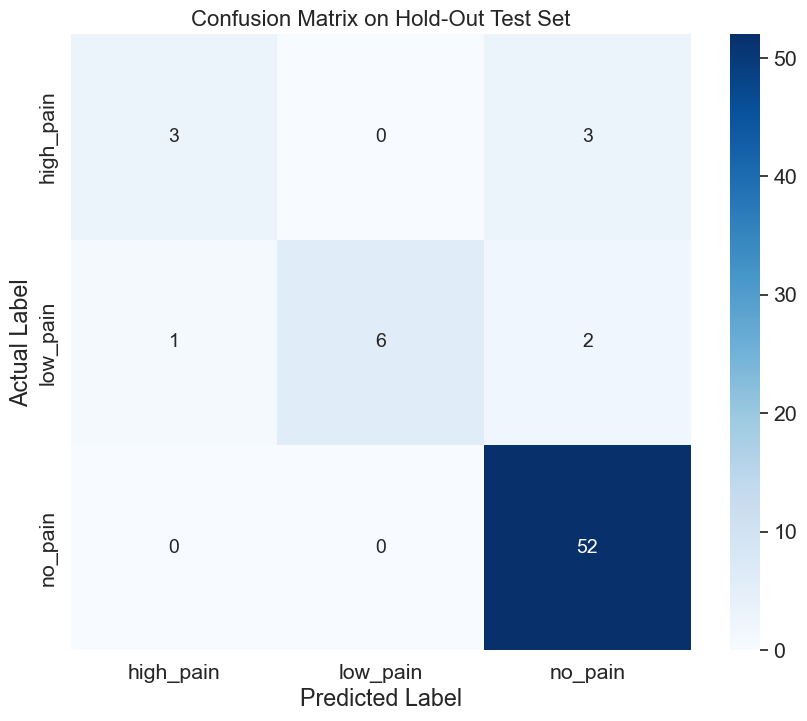

In [10]:
print("--- Preparing hold-out test set for final evaluation ---")

# Re-order test data columns to match training
X_test_reordered = np.concatenate([
    X_test[:, :, continuous_indices_orig],
    X_test[:, :, categorical_indices_orig]], axis=2)

# Use the same preprocessor that was fitted on the full training data
ns_test, ts_test, f_test = X_test_reordered.shape
X_test_scaled = preprocessor_final.transform(X_test_reordered.reshape(ns_test * ts_test, f_test)).reshape(ns_test, ts_test, f_test)

# Create sliding windows for the test set
X_test_w, _, test_window_indices = create_sliding_windows(X_test_scaled, y=y_test, window_size=FINAL_CONFIG['window_size'], stride=FINAL_CONFIG['stride'])
test_loader = make_loader(TensorDataset(torch.from_numpy(X_test_w).float()), FINAL_CONFIG['batch_size'], False, False)

all_fold_test_probabilities = []
print("\n--- Generating predictions on the hold-out test set ---")
for fold in range(N_SPLITS):
    fold_name = f"{FINAL_EXPERIMENT_NAME}_fold_{fold+1}"
    model_path = f"models/{fold_name}_best_model.pt"
    print(f"Loading model {fold+1}/{N_SPLITS} from {model_path}...")
    model_fold = RecurrentClassifier(**model_config_final, num_classes=N_CLASSES).to(device)
    model_fold.load_state_dict(torch.load(model_path, map_location=device))
    model_fold.eval()
    
    fold_test_preds = []
    with torch.no_grad():
        for (inputs,) in test_loader:
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                probs = torch.softmax(model_fold(inputs.to(device)), dim=1)
                fold_test_preds.append(probs.cpu().numpy())
    all_fold_test_probabilities.append(np.concatenate(fold_test_preds))

# --- Aggregate predictions and evaluate ---
mean_test_probabilities = np.mean(all_fold_test_probabilities, axis=0)
df_test_probs = pd.DataFrame(mean_test_probabilities, columns=[f"prob_{i}" for i in range(N_CLASSES)])
df_test_probs['original_index'] = test_window_indices
agg_test_probs = df_test_probs.groupby('original_index')[[f"prob_{i}" for i in range(N_CLASSES)]].mean().values
final_test_predictions = np.argmax(agg_test_probs, axis=1)

# Get the true labels for the original samples that had windows created
true_test_labels = y_test[np.unique(test_window_indices)]

print("\n--- Final Ensemble Performance on Hold-Out Test Set ---")

# Classification Report
class_names = le.classes_
report = classification_report(true_test_labels, final_test_predictions, target_names=class_names)
print("\nClassification Report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(true_test_labels, final_test_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix on Hold-Out Test Set', fontsize=16)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()